### LASSO parameter range experiments, summary across all genes from Vogelstein et al. 2013

`scikit-learn` has two different implementations of logistic regression: [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) (using the `liblinear` coordinate descent optimizer) and [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) (using stochastic gradient descent for optimization).

In this script we want to compare their performance and model selection dynamics across different levels of regularization, across the cancer genes in our gene set.

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
ll_results_dir = os.path.join(
    cfg.repo_root, '01_stratified_classification', 'results', 'optimizer_compare_ll_lr_range', 'gene'
)

lr_schedule = 'optimal'
sgd_results_dir = os.path.join(
    cfg.repo_root, '01_stratified_classification', 'results', f'optimizer_compare_sgd_lr_{lr_schedule}', 'gene'
)

metric = 'aupr'

output_plots = True
output_plots_dir = os.path.join(
    cfg.repo_root, '01_stratified_classification', 'optimizers_plots'
)

### Get coefficient information for each lasso penalty

In [3]:
ll_nz_coefs_df = []

# get coefficient info for training dataset specified above
for coef_info in au.generate_nonzero_coefficients_lasso_range(ll_results_dir):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        ll_nz_coefs_df.append(
            [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
ll_nz_coefs_df = pd.DataFrame(
    ll_nz_coefs_df,
    columns=['gene', 'signal', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
ll_nz_coefs_df.lasso_param = ll_nz_coefs_df.lasso_param.astype(float)

print(ll_nz_coefs_df.gene.unique())
ll_nz_coefs_df.head()

['MAP3K1' 'TP53' 'KDM5C' 'RB1' 'CIC' 'BRAF' 'JAK1' 'ARID2' 'CSF1R' 'JAK3'
 'NPM1' 'H3F3A' 'GNA11' 'PBRM1' 'MAP2K1' 'MET' 'CDKN2A' 'NCOR1' 'FLT3'
 'CREBBP' 'ALK' 'SMARCA4' 'FOXL2' 'NF2' 'BCOR' 'NRAS' 'ERBB2' 'ARID1A'
 'PDGFRA' 'AXIN1' 'MED12' 'SETBP1' 'KDM6A' 'STK11' 'NOTCH1' 'TSC1' 'STAG2'
 'SMAD4' 'ARID1B' 'FGFR2' 'FBXW7' 'EGFR' 'APC' 'IDH2' 'VHL' 'IDH1' 'EP300'
 'GATA3' 'ATRX' 'HRAS' 'GNAS' 'SMAD2' 'CTNNB1' 'PTEN' 'DNMT1' 'ABL1'
 'PIK3CA' 'NOTCH2' 'FGFR3' 'GATA2' 'CARD11' 'KIT' 'ATM' 'ASXL1' 'CDH1'
 'BAP1' 'FUBP1' 'SF3B1' 'RNF43' 'NF1' 'PRDM1' 'NFE2L2' 'BRCA2' 'PIK3R1'
 'SETD2' 'CASP8' 'SPOP' 'SOX9' 'GNAQ' 'PPP2R1A' 'KRAS' 'JAK2' 'EZH2'
 'HIST1H3B']


,gene,signal,lasso_param,seed,fold,nz_coefs
0,MAP3K1,classify,31.6,42,0,1868
1,MAP3K1,classify,31.6,42,1,1740
2,MAP3K1,classify,31.6,42,2,1963
3,MAP3K1,classify,31.6,42,3,2012
4,MAP3K1,classify,10000000.0,42,0,15372


In [4]:
sgd_nz_coefs_df = []

# get coefficient info for training dataset specified above
for coef_info in au.generate_nonzero_coefficients_lasso_range(sgd_results_dir):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        sgd_nz_coefs_df.append(
            [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
sgd_nz_coefs_df = pd.DataFrame(
    sgd_nz_coefs_df,
    columns=['gene', 'signal', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
sgd_nz_coefs_df.lasso_param = sgd_nz_coefs_df.lasso_param.astype(float)

print(sgd_nz_coefs_df.gene.unique())
sgd_nz_coefs_df.head()

['MAP3K1' 'TP53' 'KDM5C' 'RB1' 'CIC' 'BRAF' 'JAK1' 'ARID2' 'CSF1R' 'JAK3'
 'NPM1' 'H3F3A' 'GNA11' 'PBRM1' 'MAP2K1' 'MET' 'CDKN2A' 'NCOR1' 'FLT3'
 'CREBBP' 'ALK' 'SMARCA4' 'FOXL2' 'NF2' 'BCOR' 'NRAS' 'ERBB2' 'ARID1A'
 'PDGFRA' 'AXIN1' 'MED12' 'SETBP1' 'KDM6A' 'STK11' 'NOTCH1' 'TSC1' 'STAG2'
 'SMAD4' 'ARID1B' 'FGFR2' 'FBXW7' 'EGFR' 'APC' 'IDH2' 'VHL' 'IDH1' 'EP300'
 'GATA3' 'ATRX' 'HRAS' 'GNAS' 'SMAD2' 'CTNNB1' 'PTEN' 'DNMT1' 'ABL1'
 'PIK3CA' 'NOTCH2' 'FGFR3' 'GATA2' 'CARD11' 'KIT' 'ATM' 'ASXL1' 'CDH1'
 'BAP1' 'FUBP1' 'SF3B1' 'RNF43' 'NF1' 'PRDM1' 'NFE2L2' 'BRCA2' 'PIK3R1'
 'SETD2' 'CASP8' 'SPOP' 'SOX9' 'GNAQ' 'PPP2R1A' 'KRAS' 'JAK2' 'EZH2'
 'HIST1H3B']


,gene,signal,lasso_param,seed,fold,nz_coefs
0,MAP3K1,classify,0.00001,42,0,15331
1,MAP3K1,classify,0.00001,42,1,15333
2,MAP3K1,classify,0.00001,42,2,15319
3,MAP3K1,classify,0.00001,42,3,15320
4,MAP3K1,classify,31.60000,42,0,0


### Get performance information for each lasso penalty

In [5]:
ll_perf_df = au.load_prediction_results_lasso_range(ll_results_dir,
                                                    'stratified')
ll_perf_df = (ll_perf_df
    .drop(columns=['holdout_cancer_type', 'experiment'])
    .copy()
)
ll_perf_df.lasso_param = ll_perf_df.lasso_param.astype(float)

print(ll_perf_df.shape)
print(ll_perf_df.gene.unique())
ll_perf_df.head()

(42336, 8)
['MAP3K1' 'TP53' 'KDM5C' 'RB1' 'CIC' 'BRAF' 'JAK1' 'ARID2' 'CSF1R' 'JAK3'
 'NPM1' 'H3F3A' 'GNA11' 'PBRM1' 'MAP2K1' 'MET' 'CDKN2A' 'NCOR1' 'FLT3'
 'CREBBP' 'ALK' 'SMARCA4' 'FOXL2' 'NF2' 'BCOR' 'NRAS' 'ERBB2' 'ARID1A'
 'PDGFRA' 'AXIN1' 'MED12' 'SETBP1' 'KDM6A' 'STK11' 'NOTCH1' 'TSC1' 'STAG2'
 'SMAD4' 'ARID1B' 'FGFR2' 'FBXW7' 'EGFR' 'APC' 'IDH2' 'VHL' 'IDH1' 'EP300'
 'GATA3' 'ATRX' 'HRAS' 'GNAS' 'SMAD2' 'CTNNB1' 'PTEN' 'DNMT1' 'ABL1'
 'PIK3CA' 'NOTCH2' 'FGFR3' 'GATA2' 'CARD11' 'KIT' 'ATM' 'ASXL1' 'CDH1'
 'BAP1' 'FUBP1' 'SF3B1' 'RNF43' 'NF1' 'PRDM1' 'NFE2L2' 'BRCA2' 'PIK3R1'
 'SETD2' 'CASP8' 'SPOP' 'SOX9' 'GNAQ' 'PPP2R1A' 'KRAS' 'JAK2' 'EZH2'
 'HIST1H3B']


,auroc,aupr,gene,signal,seed,data_type,fold,lasso_param
0,1.00000,1.00000,MAP3K1,signal,1,train,0,100.0
1,0.59783,0.20796,MAP3K1,signal,1,test,0,100.0
2,0.62755,0.20936,MAP3K1,signal,1,cv,0,100.0
3,1.00000,1.00000,MAP3K1,signal,1,train,1,100.0
4,0.66250,0.20610,MAP3K1,signal,1,test,1,100.0


In [6]:
sgd_perf_df = au.load_prediction_results_lasso_range(sgd_results_dir,
                                                    'stratified')
sgd_perf_df = (sgd_perf_df
    .drop(columns=['holdout_cancer_type', 'experiment'])
    .copy()
)
sgd_perf_df.lasso_param = sgd_perf_df.lasso_param.astype(float)

print(sgd_perf_df.shape)
print(sgd_perf_df.gene.unique())
sgd_perf_df.head()

(42336, 8)
['MAP3K1' 'TP53' 'KDM5C' 'RB1' 'CIC' 'BRAF' 'JAK1' 'ARID2' 'CSF1R' 'JAK3'
 'NPM1' 'H3F3A' 'GNA11' 'PBRM1' 'MAP2K1' 'MET' 'CDKN2A' 'NCOR1' 'FLT3'
 'CREBBP' 'ALK' 'SMARCA4' 'FOXL2' 'NF2' 'BCOR' 'NRAS' 'ERBB2' 'ARID1A'
 'PDGFRA' 'AXIN1' 'MED12' 'SETBP1' 'KDM6A' 'STK11' 'NOTCH1' 'TSC1' 'STAG2'
 'SMAD4' 'ARID1B' 'FGFR2' 'FBXW7' 'EGFR' 'APC' 'IDH2' 'VHL' 'IDH1' 'EP300'
 'GATA3' 'ATRX' 'HRAS' 'GNAS' 'SMAD2' 'CTNNB1' 'PTEN' 'DNMT1' 'ABL1'
 'PIK3CA' 'NOTCH2' 'FGFR3' 'GATA2' 'CARD11' 'KIT' 'ATM' 'ASXL1' 'CDH1'
 'BAP1' 'FUBP1' 'SF3B1' 'RNF43' 'NF1' 'PRDM1' 'NFE2L2' 'BRCA2' 'PIK3R1'
 'SETD2' 'CASP8' 'SPOP' 'SOX9' 'GNAQ' 'PPP2R1A' 'KRAS' 'JAK2' 'EZH2'
 'HIST1H3B']


,auroc,aupr,gene,signal,seed,data_type,fold,lasso_param
0,0.98455,0.85560,MAP3K1,signal,1,train,0,0.00316
1,0.53171,0.14828,MAP3K1,signal,1,test,0,0.00316
2,0.61612,0.21166,MAP3K1,signal,1,cv,0,0.00316
3,0.99009,0.88155,MAP3K1,signal,1,train,1,0.00316
4,0.67119,0.16566,MAP3K1,signal,1,test,1,0.00316


In [7]:
# make sure gene sets are the same between optimizers
assert np.array_equal(
    sgd_perf_df.gene.sort_values().unique(),
    ll_perf_df.gene.sort_values().unique()
)

### Get "best" LASSO parameter and compare performance across all genes

Here, we'll just define the "best" model as the one with the highest validation set AUPR. We'll do this for each gene in the Vogelstein dataset, separately for each optimizer, and plot the distribution of AUPR differences between the two optimizers to give an idea of which one tends to be "better".

In [8]:
ll_top_df = []

# get top-performing lasso param for each gene,
# based on mean performance across seeds/folds
for gene in ll_perf_df.gene.unique():
    ll_mean_perf_df = (
      ll_perf_df[(ll_perf_df.gene == gene) &
                 (ll_perf_df.data_type == 'cv') &
                 (ll_perf_df.signal == 'signal')]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
          .sort_values(by='mean_aupr', ascending=False)
          .reset_index()
    )
    ll_mean_perf_df['gene'] = gene
    ll_top_df.append(ll_mean_perf_df.iloc[[0], :])
    
ll_top_df = (
    pd.concat(ll_top_df)
      .set_index('gene')
)
print(ll_top_df.shape)
ll_top_df.head()

(84, 3)


,lasso_param,mean_auroc,mean_aupr
gene,,,
MAP3K1,3.1600,0.677734,0.297060
TP53,0.0316,0.928489,0.901050
KDM5C,1.0000,0.842313,0.445836
RB1,0.0316,0.862785,0.467207
CIC,0.1000,0.886274,0.757054


In [9]:
sgd_top_df = []

# get top-performing lasso param for each gene,
# based on mean performance across seeds/folds
for gene in sgd_perf_df.gene.unique():
    sgd_mean_perf_df = (
      sgd_perf_df[(sgd_perf_df.gene == gene) &
                  (sgd_perf_df.data_type == 'cv') &
                  (sgd_perf_df.signal == 'signal')]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
          .sort_values(by='mean_aupr', ascending=False)
          .reset_index()
    )
    sgd_mean_perf_df['gene'] = gene
    sgd_top_df.append(sgd_mean_perf_df.iloc[[0], :])
    
sgd_top_df = (
    pd.concat(sgd_top_df)
      .set_index('gene')
)
print(sgd_top_df.shape)
sgd_top_df.head()

(84, 3)


,lasso_param,mean_auroc,mean_aupr
gene,,,
MAP3K1,0.003160,0.629413,0.194956
TP53,0.000001,0.905170,0.880779
KDM5C,0.316000,0.715302,0.273101
RB1,0.000003,0.797882,0.378135
CIC,0.031600,0.842491,0.543749


In [10]:
def get_top_optimizer_diff(gene):
    # TODO: put some of repeated code in functions
    ll_top_lasso_param = ll_top_df.loc[gene, 'lasso_param']
    sgd_top_lasso_param = sgd_top_df.loc[gene, 'lasso_param']
    
    ll_mean_test_perf_df = (
        ll_perf_df[(ll_perf_df.gene == gene) &
                   (ll_perf_df.data_type == 'test') &
                   (ll_perf_df.signal == 'signal')]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
    )
    sgd_mean_test_perf_df = (
        sgd_perf_df[(sgd_perf_df.gene == gene) &
                    (sgd_perf_df.data_type == 'test') &
                    (sgd_perf_df.signal == 'signal')]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
    )
    ll_sgd_diff = (
        ll_mean_test_perf_df.loc[ll_top_lasso_param, 'mean_aupr'] -
        sgd_mean_test_perf_df.loc[sgd_top_lasso_param, 'mean_aupr']
    )
    
    return [gene,
            ll_top_lasso_param,
            sgd_top_lasso_param,
            ll_sgd_diff]

print(get_top_optimizer_diff('PTEN'))

['PTEN', 0.0316, 1e-07, 0.09458124999999995]


In [11]:
all_top_optimizer_diff_df = []

for gene in ll_perf_df.gene.unique():
    all_top_optimizer_diff_df.append(
        get_top_optimizer_diff(gene)
    )
        
all_top_optimizer_diff_df = pd.DataFrame(
    all_top_optimizer_diff_df,
    columns=['gene', 'll_top_lasso_param',
             'sgd_top_lasso_param', 'll_sgd_diff']
)

all_top_optimizer_diff_df['best'] = 'liblinear'
all_top_optimizer_diff_df.loc[
    all_top_optimizer_diff_df.ll_sgd_diff < 0, 'best'
] = 'SGD'
# this probably won't happen but just in case
all_top_optimizer_diff_df.loc[
    all_top_optimizer_diff_df.ll_sgd_diff == 0, 'best'
] = 'equal'

print(all_top_optimizer_diff_df.best.value_counts())
all_top_optimizer_diff_df.head()

liblinear    72
SGD          12
Name: best, dtype: int64


,gene,ll_top_lasso_param,sgd_top_lasso_param,ll_sgd_diff,best
0,MAP3K1,3.1600,0.003160,0.175605,liblinear
1,TP53,0.0316,0.000001,0.021269,liblinear
2,KDM5C,1.0000,0.316000,0.094313,liblinear
3,RB1,0.0316,0.000003,0.117614,liblinear
4,CIC,0.1000,0.031600,0.264941,liblinear


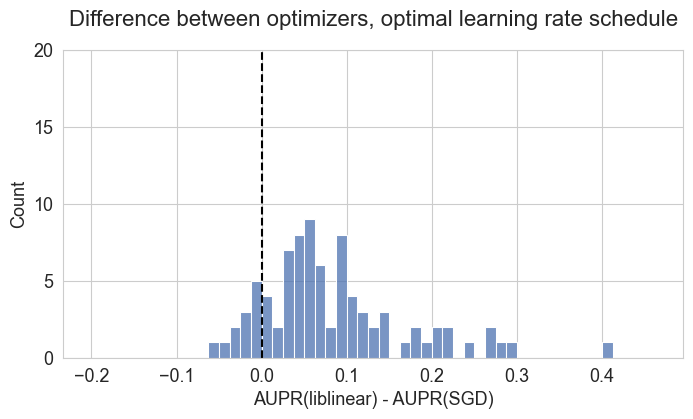

In [25]:
sns.set({'figure.figsize': (8, 4)})
sns.set_style('whitegrid')

sns.histplot(all_top_optimizer_diff_df.ll_sgd_diff, binwidth=0.0125, binrange=(-0.2, 0.45))
# plt.xlim(-0.15, 0.15)
if lr_schedule == 'constant_search':
    plt.title('Difference between optimizers, across all genes', size=16, y=1.05)
else:
    plt.title(f'Difference between optimizers, {lr_schedule} learning rate schedule', size=16, y=1.05)
plt.xlabel('AUPR(liblinear) - AUPR(SGD)', size=13)
plt.ylabel('Count', size=13)
plt.yticks(np.arange(0, 25, 5))
plt.gca().axvline(0, color='black', linestyle='--')
plt.gca().tick_params(axis='both', labelsize=13)

if output_plots:
    os.makedirs(output_plots_dir, exist_ok=True)
    plt.savefig(os.path.join(output_plots_dir, f'all_optimizers_diff_dist_{lr_schedule}.svg'), bbox_inches='tight')

In [13]:
all_top_optimizer_diff_df.sort_values(by='ll_sgd_diff', ascending=False).head(10)

,gene,ll_top_lasso_param,sgd_top_lasso_param,ll_sgd_diff,best
66,FUBP1,10.0000,1.000000e-01,0.401069,liblinear
64,CDH1,0.0316,1.000000e-01,0.292530,liblinear
81,JAK2,10.0000,3.160000e-03,0.281602,liblinear
36,STAG2,0.0316,1.000000e-06,0.269434,liblinear
4,CIC,0.1000,3.160000e-02,0.264941,liblinear
75,CASP8,10.0000,3.160000e-02,0.240956,liblinear
76,SPOP,3.1600,1.000000e-06,0.223695,liblinear
41,EGFR,0.0100,3.160000e-07,0.220172,liblinear
37,SMAD4,0.0316,3.160000e-06,0.208216,liblinear
48,ATRX,0.0316,3.160000e-03,0.207005,liblinear


In [14]:
all_top_optimizer_diff_df.sort_values(by='ll_sgd_diff', ascending=True).head(10)

,gene,ll_top_lasso_param,sgd_top_lasso_param,ll_sgd_diff,best
8,CSF1R,100.00,3.160000e-06,-0.052141,SGD
83,HIST1H3B,31.60,1.000000e-02,-0.049034,SGD
10,NPM1,10.00,3.160000e-06,-0.029779,SGD
82,EZH2,10.00,3.160000e-03,-0.026934,SGD
44,VHL,3.16,3.160000e-06,-0.019011,SGD
19,CREBBP,0.01,1.000000e-05,-0.017655,SGD
30,MED12,3.16,1.000000e-07,-0.015390,SGD
55,ABL1,100.00,1.000000e-05,-0.010077,SGD
62,ATM,0.01,1.000000e-06,-0.008480,SGD
38,ARID1B,316.00,1.000000e-01,-0.003709,SGD


### Compare feature selection with performance

In [15]:
ll_coefs_perf_df = (ll_top_df
    .reset_index()
    .merge(ll_nz_coefs_df,
           on=['gene', 'lasso_param'])
    .drop(columns=['signal'])
)
ll_coefs_perf_df['optimizer'] = 'liblinear'

print(ll_coefs_perf_df.shape)
ll_coefs_perf_df.head()

(672, 8)


,gene,lasso_param,mean_auroc,mean_aupr,seed,fold,nz_coefs,optimizer
0,MAP3K1,3.16,0.677734,0.29706,1,0,453,liblinear
1,MAP3K1,3.16,0.677734,0.29706,1,1,731,liblinear
2,MAP3K1,3.16,0.677734,0.29706,1,2,518,liblinear
3,MAP3K1,3.16,0.677734,0.29706,1,3,441,liblinear
4,MAP3K1,3.16,0.677734,0.29706,42,0,494,liblinear


In [16]:
sgd_coefs_perf_df = (sgd_top_df
    .reset_index()
    .merge(sgd_nz_coefs_df,
           on=['gene', 'lasso_param'])
    .drop(columns=['signal'])
)
sgd_coefs_perf_df['optimizer'] = 'SGD'

print(sgd_coefs_perf_df.shape)
print(sgd_coefs_perf_df.nz_coefs.min(), sgd_coefs_perf_df.nz_coefs.max())
sgd_coefs_perf_df.head()

(672, 8)
1 15384


,gene,lasso_param,mean_auroc,mean_aupr,seed,fold,nz_coefs,optimizer
0,MAP3K1,0.00316,0.629413,0.194956,1,0,11173,SGD
1,MAP3K1,0.00316,0.629413,0.194956,1,1,11341,SGD
2,MAP3K1,0.00316,0.629413,0.194956,1,2,10044,SGD
3,MAP3K1,0.00316,0.629413,0.194956,1,3,11004,SGD
4,MAP3K1,0.00316,0.629413,0.194956,42,0,10653,SGD


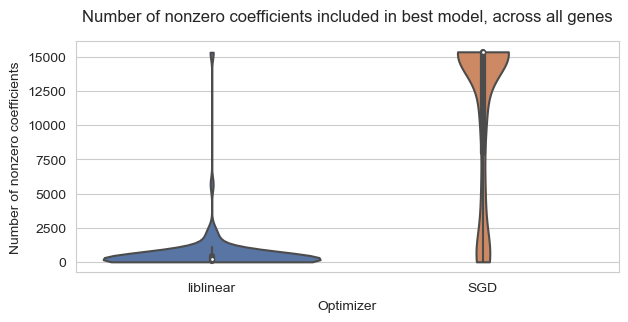

In [17]:
sns.set({'figure.figsize': (7, 3)})
sns.set_style('whitegrid')

coefs_perf_df = pd.concat((ll_coefs_perf_df, sgd_coefs_perf_df))
sns.violinplot(data=coefs_perf_df, x='optimizer', y='nz_coefs', cut=0)
plt.title('Number of nonzero coefficients included in best model, across all genes', y=1.05)
plt.xlabel('Optimizer')
plt.ylabel('Number of nonzero coefficients')

if output_plots:
    plt.savefig(os.path.join(output_plots_dir, f'all_optimizers_coef_count_dist_{lr_schedule}.svg'), bbox_inches='tight')

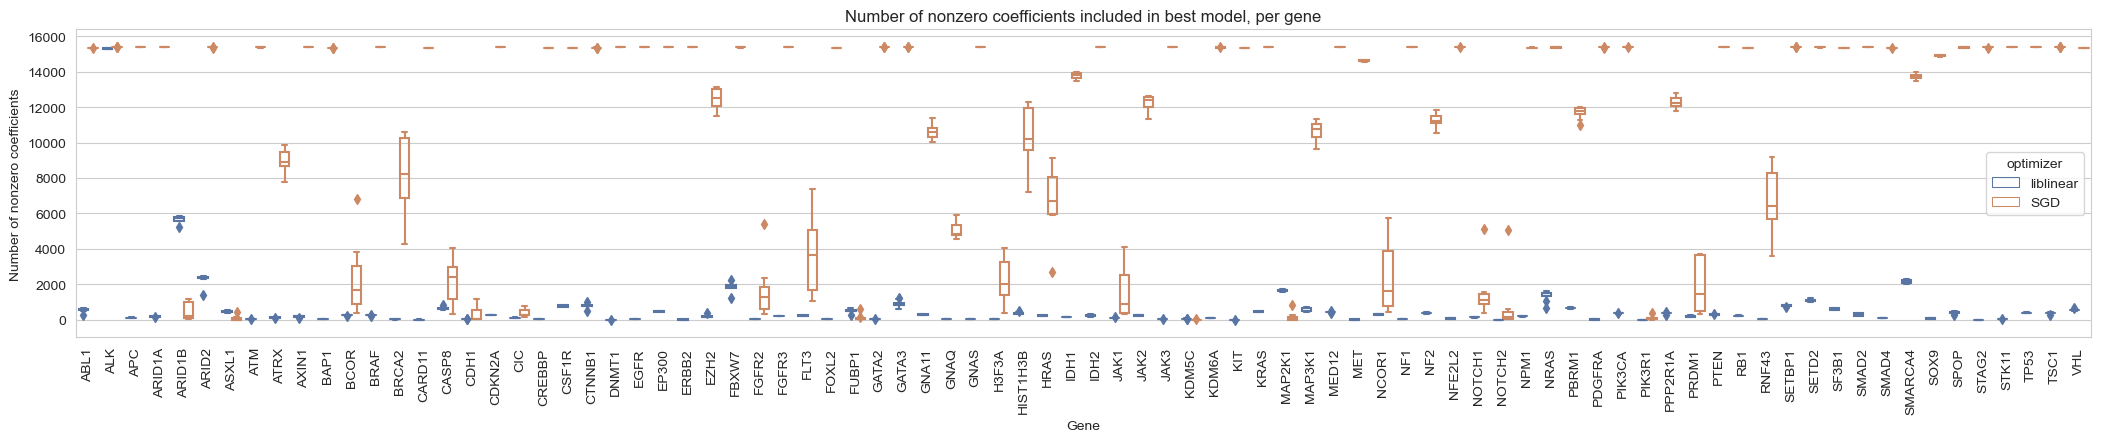

In [18]:
import matplotlib.patches
sns.set({'figure.figsize': (26, 4)})
sns.set_style('whitegrid')

sns.boxplot(data=coefs_perf_df.sort_values(by='gene'),
            x='gene', y='nz_coefs', hue='optimizer')
plt.title('Number of nonzero coefficients included in best model, per gene')
plt.xlabel('Gene')
plt.xticks(rotation=90)
plt.ylabel('Number of nonzero coefficients')
plt.ylim(-1000, coefs_perf_df.nz_coefs.max()+1000)

# color the boxplot lines/edges rather than the box fill
# this makes it easier to discern colors at the extremes; i.e. very many or few nonzero coefs
# https://stackoverflow.com/a/72333641
def color_boxes(ax):
    box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
    num_patches = len(box_patches)
    lines_per_boxplot = len(ax.lines) // num_patches
    for i, patch in enumerate(box_patches):
        # set the linecolor on the patch to the facecolor, and set the facecolor to None
        col = patch.get_facecolor()
        patch.set_edgecolor(col)
        patch.set_facecolor('None')

        # each box has associated Line2D objects (to make the whiskers, fliers, etc.)
        # loop over them here, and use the same color as above
        for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
            line.set_color(col)
            line.set_mfc(col)  # facecolor of fliers
            line.set_mec(col)  # edgecolor of fliers
            
    # also fix the legend to color the edges rather than fill
    for legpatch in ax.legend_.get_patches():
        col = legpatch.get_facecolor()
        legpatch.set_edgecolor(col)
        legpatch.set_facecolor('None')
            
color_boxes(plt.gca())

if output_plots:
    plt.savefig(os.path.join(output_plots_dir, f'all_optimizers_coef_count_per_gene_{lr_schedule}.png'), bbox_inches='tight')

### Get difference between "best" and "largest" (least regularized) models

We can use this to determine how much a model overfits: that is, as model complexity increases, how much (or if at all) performance decreases from its peak.

In [19]:
def get_top_largest_diff(gene):
    # TODO: put some of repeated code in functions
    ll_top_lasso_param = ll_top_df.loc[gene, 'lasso_param']
    sgd_top_lasso_param = sgd_top_df.loc[gene, 'lasso_param']
    
    ll_mean_test_perf_df = (
        ll_perf_df[(ll_perf_df.gene == gene) &
                   (ll_perf_df.data_type == 'test') &
                   (ll_perf_df.signal == 'signal')]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
    )
    sgd_mean_test_perf_df = (
        sgd_perf_df[(sgd_perf_df.gene == gene) &
                    (sgd_perf_df.data_type == 'test') &
                    (sgd_perf_df.signal == 'signal')]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
    )
    
    # use maximum liblinear parameter = largest (least regularized) model
    ll_top_largest_diff = (
        ll_mean_test_perf_df.loc[ll_top_lasso_param, 'mean_aupr'] -
        ll_mean_test_perf_df.loc[ll_perf_df.lasso_param.max(), 'mean_aupr']
    )
    # use minimum SGD parameter = largest (least regularized) model
    sgd_top_largest_diff = (
        sgd_mean_test_perf_df.loc[sgd_top_lasso_param, 'mean_aupr'] -
        sgd_mean_test_perf_df.loc[sgd_perf_df.lasso_param.min(), 'mean_aupr']
    )
    
    return [gene,
            ll_top_lasso_param,
            sgd_top_lasso_param,
            ll_top_largest_diff,
            sgd_top_largest_diff]

print(get_top_largest_diff('PTEN'))

['PTEN', 0.0316, 1e-07, 0.40956375, 0.0]


In [20]:
all_top_largest_diff_df = []

for gene in ll_perf_df.gene.unique():
    all_top_largest_diff_df.append(
        get_top_largest_diff(gene)
    )
        
all_top_largest_diff_df = pd.DataFrame(
    all_top_largest_diff_df,
    columns=['gene',
             'll_top_lasso_param',
             'sgd_top_lasso_param',
             'll_top_largest_diff',
             'sgd_top_largest_diff']
)

all_top_largest_diff_df['largest_diff'] = 'liblinear'
all_top_largest_diff_df.loc[
    all_top_largest_diff_df.ll_top_largest_diff < all_top_largest_diff_df.sgd_top_largest_diff,
    'largest_diff'
] = 'SGD'
# this probably won't happen but just in case
all_top_largest_diff_df.loc[
    all_top_largest_diff_df.ll_top_largest_diff == all_top_largest_diff_df.sgd_top_largest_diff,
    'largest_diff'
] = 'equal'

print(all_top_largest_diff_df.largest_diff.value_counts())
all_top_largest_diff_df.head()

liblinear    83
SGD           1
Name: largest_diff, dtype: int64


,gene,ll_top_lasso_param,sgd_top_lasso_param,ll_top_largest_diff,sgd_top_largest_diff,largest_diff
0,MAP3K1,3.1600,0.003160,0.256632,-0.055626,liblinear
1,TP53,0.0316,0.000001,0.039791,-0.001800,liblinear
2,KDM5C,1.0000,0.316000,0.246215,-0.059127,liblinear
3,RB1,0.0316,0.000003,0.225388,-0.021717,liblinear
4,CIC,0.1000,0.031600,0.522636,-0.142412,liblinear


In [21]:
plot_df = (all_top_largest_diff_df
    .rename(columns={'ll_top_largest_diff': 'liblinear',
                     'sgd_top_largest_diff': 'SGD'})
    .melt(
        id_vars=['gene', 'll_top_lasso_param', 'sgd_top_lasso_param', 'largest_diff'],
        var_name='optimizer',
        value_name='top_largest_diff'
    )
)

plot_df.head()

,gene,ll_top_lasso_param,sgd_top_lasso_param,largest_diff,optimizer,top_largest_diff
0,MAP3K1,3.1600,0.003160,liblinear,liblinear,0.256632
1,TP53,0.0316,0.000001,liblinear,liblinear,0.039791
2,KDM5C,1.0000,0.316000,liblinear,liblinear,0.246215
3,RB1,0.0316,0.000003,liblinear,liblinear,0.225388
4,CIC,0.1000,0.031600,liblinear,liblinear,0.522636


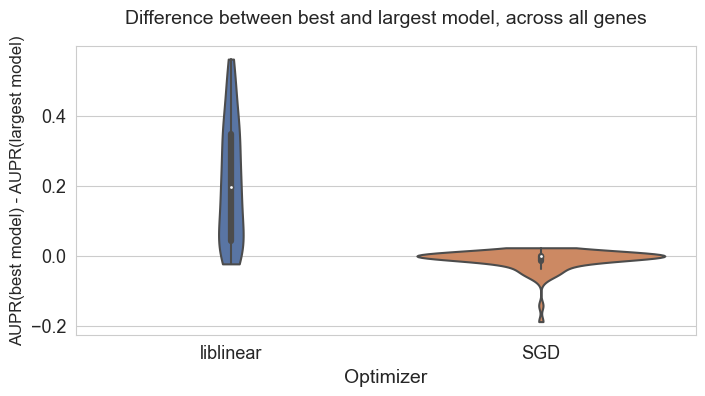

In [22]:
sns.set({'figure.figsize': (8, 3.75)})
sns.set_style('whitegrid')

sns.violinplot(data=plot_df, x='optimizer', y='top_largest_diff', cut=0)
plt.title('Difference between best and largest model, across all genes', y=1.05, size=14)
plt.xlabel('Optimizer', size=14)
plt.ylabel('AUPR(best model) - AUPR(largest model)', size=12)
plt.gca().tick_params(axis='both', labelsize=13)

if output_plots:
    plt.savefig(os.path.join(output_plots_dir, f'all_optimizers_best_vs_largest_{lr_schedule}.svg'), bbox_inches='tight')

In [23]:
# genes that overfit the most using liblinear
(all_top_largest_diff_df
  .sort_values(by='ll_top_largest_diff', ascending=False)
  .head(10)
)

,gene,ll_top_lasso_param,sgd_top_lasso_param,ll_top_largest_diff,sgd_top_largest_diff,largest_diff
41,EGFR,0.0100,3.160000e-07,0.561521,0.000032,liblinear
66,FUBP1,10.0000,1.000000e-01,0.525544,-0.188458,liblinear
4,CIC,0.1000,3.160000e-02,0.522636,-0.142412,liblinear
52,CTNNB1,3.1600,1.000000e-06,0.512695,-0.008746,liblinear
35,TSC1,31.6000,3.160000e-07,0.510633,0.004924,liblinear
47,GATA3,10.0000,1.000000e-07,0.506976,0.000000,liblinear
58,FGFR3,1.0000,3.160000e-07,0.473744,-0.013395,liblinear
26,ERBB2,0.0100,3.160000e-07,0.467172,-0.002619,liblinear
42,APC,0.0316,1.000000e-07,0.440383,0.000000,liblinear
76,SPOP,3.1600,1.000000e-06,0.439362,-0.004623,liblinear


In [24]:
# genes that overfit the most using SGD
(all_top_largest_diff_df
  .sort_values(by='sgd_top_largest_diff', ascending=False)
  .head(10)
)

,gene,ll_top_lasso_param,sgd_top_lasso_param,ll_top_largest_diff,sgd_top_largest_diff,largest_diff
74,SETD2,10.0000,1.000000e-06,0.350949,0.022510,liblinear
67,SF3B1,10.0000,1.000000e-05,0.354074,0.016006,liblinear
32,KDM6A,0.0316,1.000000e-06,0.193270,0.013351,liblinear
46,EP300,1.0000,3.160000e-07,0.076448,0.012446,liblinear
25,NRAS,10.0000,1.000000e-06,0.403920,0.010470,liblinear
56,PIK3CA,0.0316,3.160000e-07,0.160834,0.010106,liblinear
13,PBRM1,10.0000,3.160000e-03,0.129126,0.009734,liblinear
60,CARD11,0.0100,1.000000e-05,0.138311,0.009544,liblinear
36,STAG2,0.0316,1.000000e-06,0.345368,0.009155,liblinear
22,FOXL2,0.0316,1.000000e-05,0.134712,0.006580,liblinear
